tgb - 3/23/2020 - Figures for Pierre and Veronika's book chapter.  
1) Precipitation (lat/lon)  
2) Vertical profiles

# Initialization

## Imports

In [76]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag

import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

## Plot properties

In [77]:
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [78]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Load Optimized Neural Network

In [79]:
NNarray = ['JNNL','JNNL0.01','JNNC','MLRL0']
NNname = ['$\mathrm{UCnet}$','$\mathrm{LCnet_{0.01}}$','$\mathrm{ACnet}$','$\mathrm{Linear}$']
DATASET = ['train','valid','test']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
#path_SPCAM = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_SPCAM = '/local/Tom.Beucler/SPCAM_PHYS/'
data_fn = path_SPCAM+'8col009_01_test.nc'
pathHOME = '/home/t/Tom.Beucler/For_Pierre/'

In [80]:
datas = 'test'
NNs = 'JNNL'
# 1) Load model
print('Loading model')
path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
NN = load_model(path,custom_objects=dict_lay)

# 2) Define model diagnostics object
print('Building model diagnostics object')
md = ModelDiagnostics(NN,config_fn,data_fn)

# 3) Calculate statistics and save in pickle file
print('Calculating mean-squared error')
path = TRAINDIR+'HDF5_DATA/'+NNs+'md_'+datas+'.pkl'
md.stats = pickle.load(open(path,'rb'))

# 4) Residual
print('Calculating residuals')
path = TRAINDIR+'HDF5_DATA/'+NNs+'res_'+datas+'.pkl'
md.res = pickle.load(open(path,'rb'))

Loading model
Building model diagnostics object


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating mean-squared error
Calculating residuals


In [81]:
md.stats.keys()

dict_keys(['bias', 'mse', 'pred_mean', 'true_mean', 'pred_sqmean', 'true_sqmean', 'pred_var', 'true_var', 'r2', 'hor_tsqmean', 'hor_tmean', 'hor_mse', 'hor_tvar', 'hor_r2'])

In [82]:
md.stats['bias'].shape

(64, 128, 218)

In [83]:
md.valid_gen.output_vars

['PHQ',
 'PHCLDLIQ',
 'PHCLDICE',
 'TPHYSTND',
 'QRL',
 'QRS',
 'DTVKE',
 'FSNT',
 'FSNS',
 'FLNT',
 'FLNS',
 'PRECT',
 'PRECTEND',
 'PRECST',
 'PRECSTEN']

# Precipitation plot

In [84]:
md.stats['true_mean'][:,:,-4:-2].shape

(64, 128, 2)

In [85]:
P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day
# PRECtruth = np.sum(md.stats['true_mean'][:,:,-4:-2],axis=2)*P_CONV/(L_V*RHO_L)
# PRECpred = np.sum(md.stats['pred_mean'][:,:,-4:-2],axis=2)*P_CONV/(L_V*RHO_L)
OLRtruth = md.stats['true_mean'][:,:,-6]
OLRpred = md.stats['pred_mean'][:,:,-6]

In [86]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

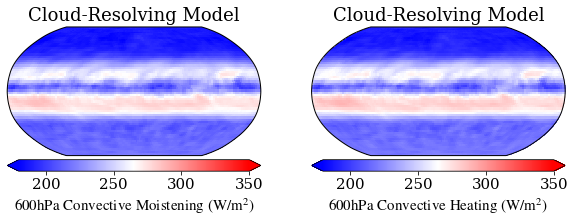

In [87]:
plt.close('all')

fig,ax = plt.subplots(1,2,figsize=(10,7.5),subplot_kw=dict(projection=ccrs.Robinson()))

# (a) Convective Moistening
im = ax[0].imshow(OLRtruth,cmap='bwr',vmin=180,vmax=350,transform=ccrs.PlateCarree())
ax[0].set_title('Cloud-Resolving Model')
cb = fig.colorbar(im, ax=ax[0], pad=0.01, extend='both', orientation='horizontal'); 
cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$')

# (b) Convective Heating
im = ax[1].imshow(OLRpred,cmap='bwr',vmin=180,vmax=350,transform=ccrs.PlateCarree())
ax[1].set_title('Cloud-Resolving Model')
cb = fig.colorbar(im, ax=ax[1], pad=0.01, extend='both', orientation='horizontal'); 
cb.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$')

# Vertical profiles

In [88]:
md.stats['true_var'].shape

(64, 128, 218)

In [89]:
md.get_output_var_idx('PHQ')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [90]:
md.valid_gen.output_transform.scale.shape

(218,)

Text(0.5, 0.98, 'Thermodynamic profiles predicted by the neural network in units: $\\mathrm{W\\ m^{-2}}$')

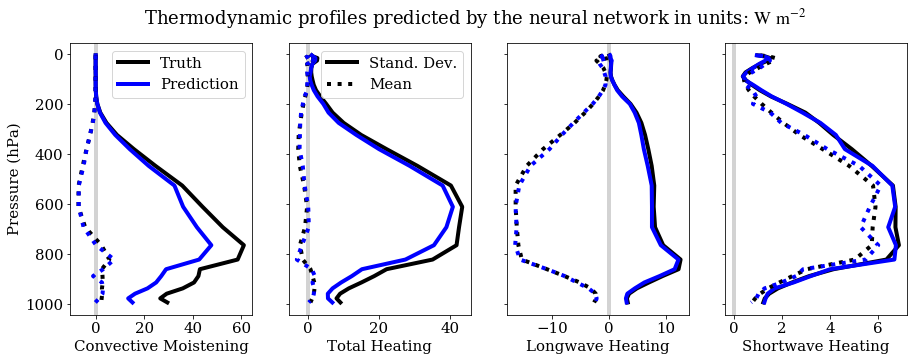

In [91]:
fig,ax = plt.subplots(1,4,figsize=(15,5))

VARS = ['PHQ','TPHYSTND','QRL','QRS']
NAME = ['Convective Moistening','Total Heating','Longwave Heating','Shortwave Heating']
for ivar,var in enumerate(VARS):

    ax[ivar].axvline(x=0,c='lightgray')
    
    if ivar!=1:
        ax[ivar].plot(np.mean(np.sqrt(md.stats['true_var'][:,:,md.get_output_var_idx(var)])*\
                         md.valid_gen.output_transform.scale[md.get_output_var_idx(var)],\
                         axis=(0,1)),lev,label='Truth',color='k')
        ax[ivar].plot(np.mean(np.sqrt(md.stats['pred_var'][:,:,md.get_output_var_idx(var)])*\
                         md.valid_gen.output_transform.scale[md.get_output_var_idx(var)],\
                         axis=(0,1)),lev,label='Prediction',color='b')
        ax[ivar].plot(np.mean(md.stats['true_mean'][:,:,md.get_output_var_idx(var)]*\
                         md.valid_gen.output_transform.scale[md.get_output_var_idx(var)],\
                         axis=(0,1)),lev,color='k',linestyle=':')
        ax[ivar].plot(np.mean(md.stats['pred_mean'][:,:,md.get_output_var_idx(var)]*\
                         md.valid_gen.output_transform.scale[md.get_output_var_idx(var)],\
                         axis=(0,1)),lev,color='b',linestyle=':')
    elif ivar==1:
        ax[ivar].plot(np.mean(np.sqrt(md.stats['true_var'][:,:,md.get_output_var_idx(var)])*\
                         md.valid_gen.output_transform.scale[md.get_output_var_idx(var)],\
                         axis=(0,1)),lev,color='k',label='Stand. Dev.')
        ax[ivar].plot(np.mean(np.sqrt(md.stats['pred_var'][:,:,md.get_output_var_idx(var)])*\
                         md.valid_gen.output_transform.scale[md.get_output_var_idx(var)],\
                         axis=(0,1)),lev,color='b')
        ax[ivar].plot(np.mean(md.stats['true_mean'][:,:,md.get_output_var_idx(var)]*\
                         md.valid_gen.output_transform.scale[md.get_output_var_idx(var)],\
                         axis=(0,1)),lev,color='k',linestyle=':',label='Mean')
        ax[ivar].plot(np.mean(md.stats['pred_mean'][:,:,md.get_output_var_idx(var)]*\
                         md.valid_gen.output_transform.scale[md.get_output_var_idx(var)],\
                         axis=(0,1)),lev,color='b',linestyle=':')
        ax[ivar].legend()
        

    ax[ivar].set_xlabel(NAME[ivar])
    ax[ivar].invert_yaxis()

    if ivar==0:
        ax[ivar].legend()
        ax[ivar].set_ylabel('Pressure (hPa)')
    else:
        ax[ivar].tick_params(labelleft=False) 
        
fig.suptitle("Thermodynamic profiles predicted by the neural network in units: $\mathrm{W\ m^{-2}}$")

#name = 'CQ3'
#plt.savefig(pathHOME+name+'.png',format='png')

# Conserving NN figure

In [92]:
NNarray = ['JNNL','JNNC']

In [93]:
DATASET = ['train','valid','test']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
#path_SPCAM = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_SPCAM = '/local/Tom.Beucler/SPCAM_PHYS/'
data_fn = path_SPCAM+'8col009_01_test.nc'
pathHOME = '/home/t/Tom.Beucler/For_Pierre/'

In [94]:
datas = 'test'
NNs = 'JNNC'
# 1) Load model
print('Loading model')
path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
NNC = load_model(path,custom_objects=dict_lay)

# 2) Define model diagnostics object
print('Building model diagnostics object')
mdC = ModelDiagnostics(NN,config_fn,data_fn)

# 3) Calculate statistics and save in pickle file
print('Calculating mean-squared error')
path = TRAINDIR+'HDF5_DATA/'+NNs+'md_'+datas+'.pkl'
mdC.stats = pickle.load(open(path,'rb'))

# 4) Residual
print('Calculating residuals')
path = TRAINDIR+'HDF5_DATA/'+NNs+'res_'+datas+'.pkl'
mdC.res = pickle.load(open(path,'rb'))

Loading model
Building model diagnostics object
Calculating mean-squared error
Calculating residuals


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [95]:
mdC.res.keys()

dict_keys(['ent', 'mass', 'lw', 'sw'])

In [96]:
VARname = ['Enthalpy','Mass','Longwave','Shortwave']

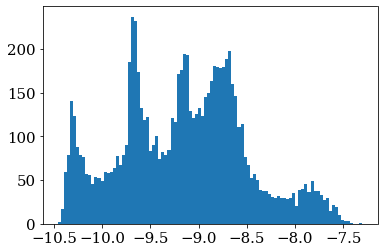

In [97]:
plt.hist(np.log10(mdC.res['ent'][:,:,0]).flatten(),bins=100);

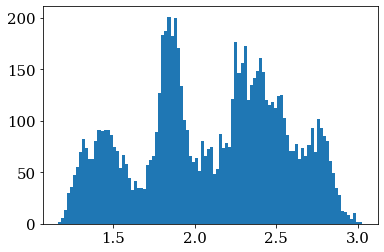

In [98]:
plt.hist(np.log10(md.res['ent'][:,:,0]).flatten(),bins=100);

In [99]:
histC = {}
bin_edgC = {}
for ikey,key in enumerate(mdC.res.keys()):
    histC[key],bin_edgC[key] = np.histogram(np.log10(np.maximum(mdC.res[key][:,:,0],1e-13)).flatten(),
                 bins=50, range=None, normed=None, weights=None, density=None)

In [100]:
hist = {}
bin_edg = {}
for ikey,key in enumerate(mdC.res.keys()):
    hist[key],bin_edg[key] = np.histogram(np.log10(md.res[key][:,:,0]).flatten(),
                 bins=50, range=None, normed=None, weights=None, density=None)

In [101]:
def edg2mid(bin_edges):
    return 0.5*(bin_edges[:-1]+bin_edges[1:])

In [108]:
fz = 30

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

COLOR = ['orange','black','b','r']

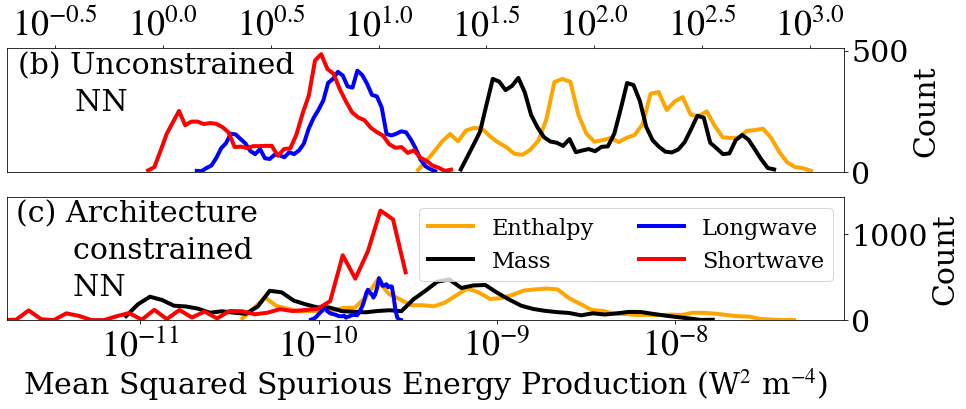

In [114]:
fig,ax = plt.subplots(2,1,figsize=(15,5))

### Non conserving network
for ikey,key in enumerate(mdC.res.keys()):
    ax[0].plot(edg2mid(bin_edg[key]),hist[key],label=VARname[ikey],color=COLOR[ikey])
#ax[0].legend()
ax[0].xaxis.tick_top()
#ax[0].set_xlabel('Unconstrained NN: Root-mean Spurious Source of Energy (W m$^{-2}$)')    
ax[0].set_ylabel('Count')
ax[0].xaxis.set_label_position('top')
ax[0].yaxis.set_label_position('right')
ax[0].yaxis.tick_right()
YMAX = ax[0].get_ylim()[1]
ax[0].set_ylim(0,YMAX)
ax[0].set_xlim(ax[0].get_xlim()[0]-0.5,ax[0].get_xlim()[1])
plt.draw()
# Change y labels to 10^n
labels = [item.get_text() for item in ax[0].get_xticklabels()]
for ilab,lab in enumerate(labels):
    labels[ilab]='$10^{'+lab+'}$';
ax[0].set_xticklabels(labels);
XMIN = ax[0].get_xlim()[0]
ax[0].set_xticklabels(labels,fontsize=1.2*fz);
ax[0].text(x=XMIN+0.05,y=0.8*YMAX,s='(b) Unconstrained')
ax[0].text(x=XMIN+0.05,y=0.5*YMAX,s='      NN')

### Conserving network
for ikey,key in enumerate(mdC.res.keys()):
    ax[1].plot(edg2mid(bin_edgC[key]),histC[key],label=VARname[ikey],color=COLOR[ikey])
ax[1].legend(ncol=2,loc='upper right',fontsize=0.75*fz)
YMAX = ax[1].get_ylim()[1]+100
ax[1].set_ylim(0,YMAX)
ax[1].set_ylabel('Count')
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
ax[1].set_xlim(ax[1].get_xlim()[0]+1.5,ax[1].get_xlim()[1])
plt.draw()
# Change y labels to 10^n
labels = [item.get_text() for item in ax[1].get_xticklabels()]
for ilab,lab in enumerate(labels):
    labels[ilab]='$10^{'+lab+'}$';
XMIN = ax[1].get_xlim()[0]
ax[1].set_xticklabels(labels,fontsize=1.2*fz);
ax[1].text(x=XMIN+0.05,y=0.8*YMAX,s='(c) Architecture')
ax[1].text(x=XMIN+0.05,y=0.5*YMAX,s='      constrained')
ax[1].text(x=XMIN+0.05,y=0.2*YMAX,s='      NN')
ax[1].set_xlabel('Mean Squared Spurious Energy Production (W$^{2}$ m$^{-4}$)')

name = 'Ch20_ACnet_bc'
plt.savefig(pathHOME+name+'.png',format='png')
plt.savefig(pathHOME+name+'.pdf',format='pdf')